In [1]:
# Third-party
import numpy as np

import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.io import fits

# Project
import artpop

# Load matplotlib style
plt.style.use('jpg.mplstyle')

# need AB magnitudes to use ArtImager
zpt_convert = artpop.load_zero_point_converter()

In [2]:
xy_dim = [701, 501]
phot_system ='HST_ACSWF'
bands = [f'ACS_WFC_{b}' for b in ['F814W','F606W','F475W']]
pixel_scale = 0.05
exptime = 90 * u.min

# read in Tiny Tim-modeled PSFs
zoom = 120
psf = {b: fits.getdata(f'../data/{b}.fits')[zoom:-zoom, zoom:-zoom] for b in bands}

# Initialize art imager
imager = artpop.ArtImager(phot_system, diameter=2.4, read_noise=3)

In [3]:
log_age = 9.
feh = -1
sbs = [26.0, 23.0, 20.0]
sb_band = 'ACS_WFC_F814W'
distances = np.array([8, 2, 0.5]) * u.Mpc

8.0 Mpc 26.0
25.97, number of stars: 0.72711 million
8.0 Mpc 23.0
23.00, number of stars: 11.523931 million
8.0 Mpc 20.0
setting mag limit for discrete sources
20.01, number of stars: 17.064379 million
2.0 Mpc 26.0
26.03, number of stars: 0.045444 million
2.0 Mpc 23.0
22.97, number of stars: 0.720245 million
2.0 Mpc 20.0
setting mag limit for discrete sources
20.00, number of stars: 1.066578 million
0.5 Mpc 26.0
25.87, number of stars: 0.00284 million
0.5 Mpc 23.0
23.11, number of stars: 0.045015 million
0.5 Mpc 20.0
setting mag limit for discrete sources
19.98, number of stars: 0.066655 million


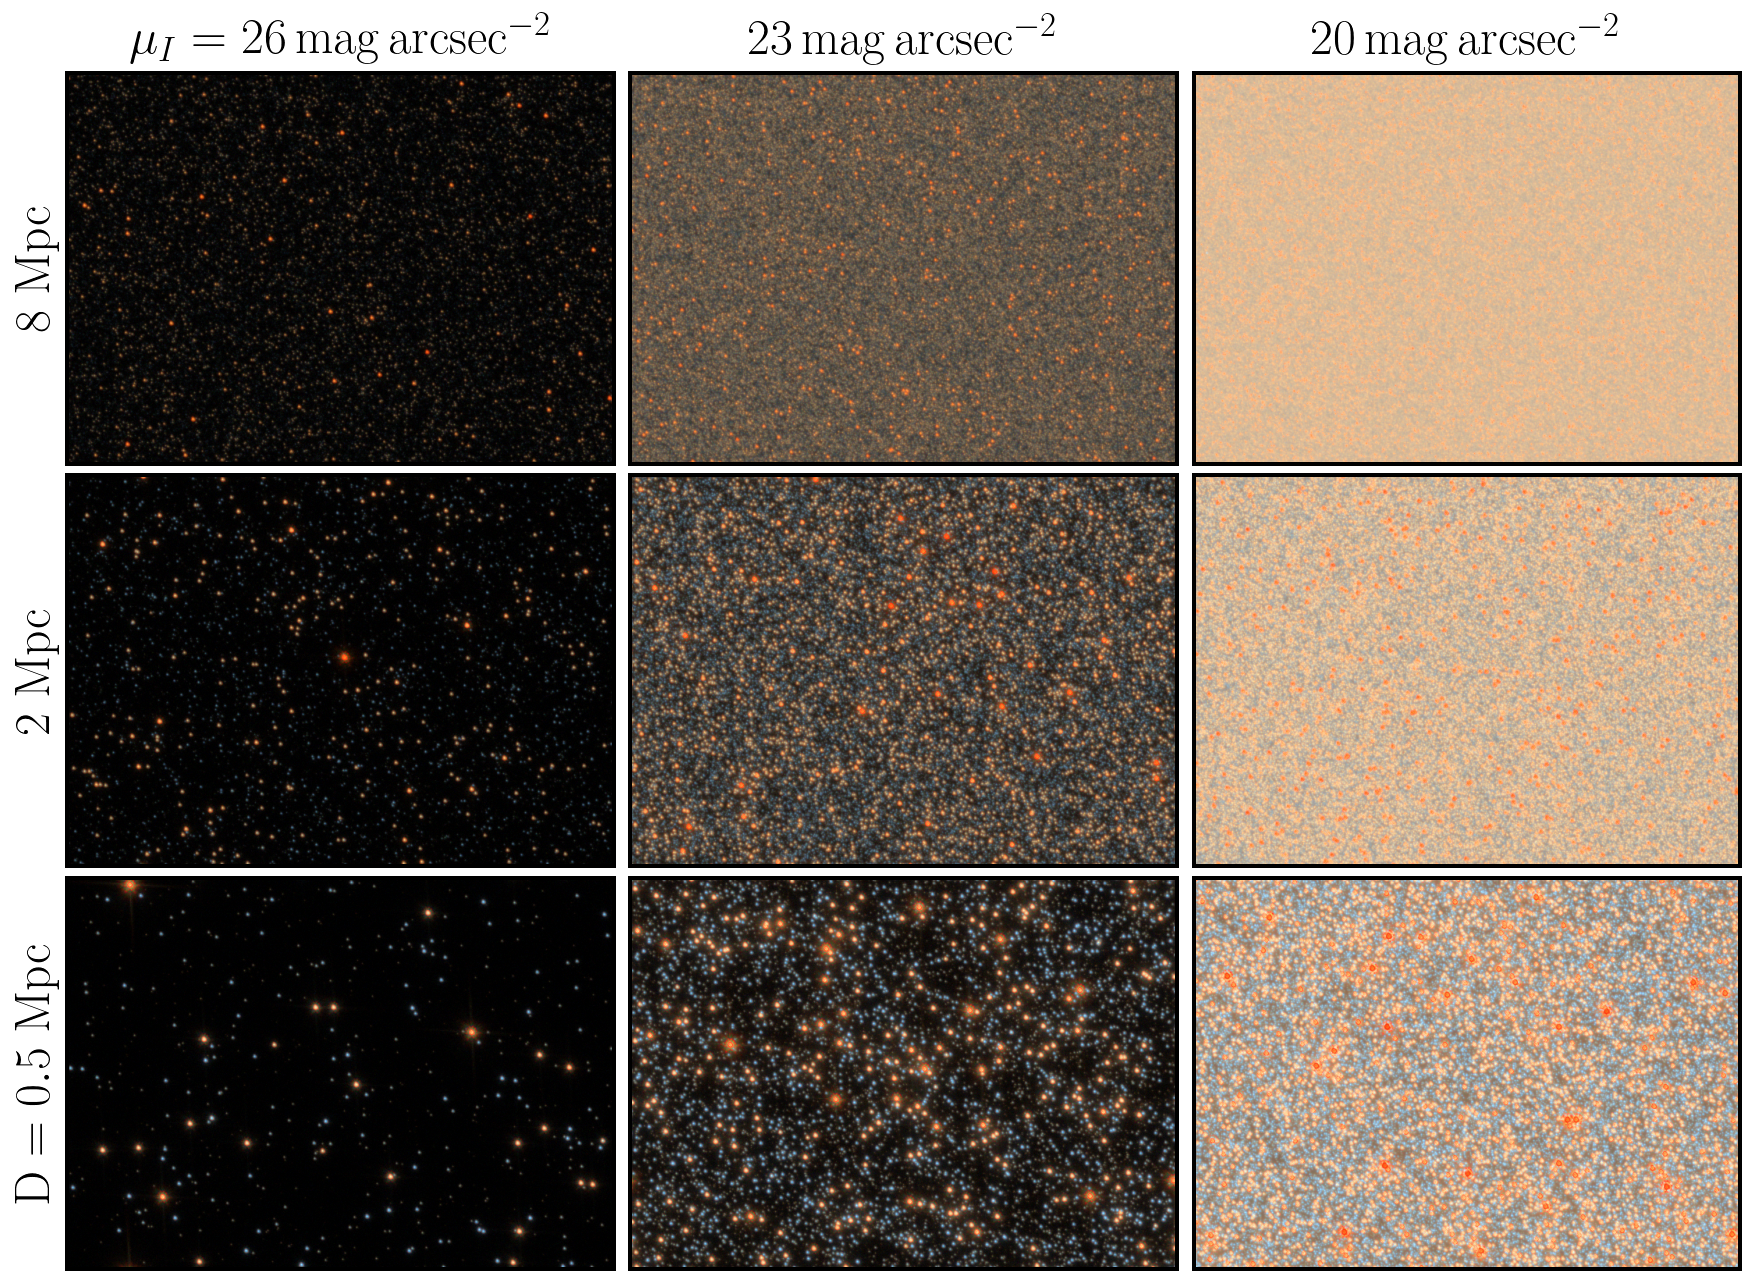

In [6]:
fig, axes = plt.subplots(len(distances), len(sbs), figsize=(15, int(15.5 * xy_dim[1]/xy_dim[0])),
                         subplot_kw=dict(xticks=[], yticks=[]))

fig.subplots_adjust(wspace=0.03, hspace=0.03)


title_fs = 25
unit_lab = '\,\mathrm{mag\,arcsec}^{-2}$'

y = 1.015

axes[0, 0].set_title('$\mu_I = ' + str(int(sbs[0])) + unit_lab, fontsize=title_fs, y=y)
axes[0, 1].set_title('$' + str(int(sbs[1])) + unit_lab, fontsize=title_fs, y=y)
axes[0, 2].set_title('$' + str(int(sbs[2])) + unit_lab, fontsize=title_fs, y=y)

unit_lab = r'\ Mpc}$'
axes[2, 0].set_ylabel(r'$\mathrm{D = ' + str(distances[2].value) + unit_lab, fontsize=title_fs)
axes[1, 0].set_ylabel(r'$\mathrm{' + str(int(distances[1].value)) + unit_lab, fontsize=title_fs)
axes[0, 0].set_ylabel(r'$\mathrm{' + str(int(distances[0].value)) + unit_lab, fontsize=title_fs)

axes = axes.flatten()

q = 8
stretch = 0.1
i = 0

for distance in distances:
    
    # create MIST uniform spatial distribution SSP sources at various sb
    for sb in sbs:
        print(distance, sb)
        mag_lim_kw = dict(mag_limit=None, mag_limit_band=None)
        dist_mod = 5 * np.log10(distance.to('pc').value) - 5
        if sb == 20:
            print('setting mag limit for discrete sources')
            mag_lim_kw = dict(mag_limit=dist_mod + 4.5, mag_limit_band=sb_band)
        src = artpop.MISTUniformSSP(
            log_age, feh, phot_system,
            distance, xy_dim, pixel_scale,
            sb, sb_band, **mag_lim_kw
        )
        images = []
        
        # mock observe in F474W, F606W, and F814W
        for num, band in enumerate(bands):
            sky_sb = 27
            zpt = 25 - zpt_convert.to_ab(band)
            obs = imager.observe(src, band, exptime, psf=psf[band],
                                 sky_sb=sky_sb, zpt=zpt)
            images.append(obs.image)
            
        zpt = 25 - zpt_convert.to_ab('ACS_WFC_F814W') 
        image_sb = (zpt - 2.5 * np.log10(np.sum(images[0]))) + 2.5 * np.log10(np.product(xy_dim) * pixel_scale**2)
        print(f'{image_sb:.2f}, number of stars: {len(src.xy)/1e6} million')

        # create RGB image
        stretch = {26.0: 0.002, 23.0: 0.02, 20.0: 0.098}[sb]
        stretch = 0.01
        rgb = make_lupton_rgb(*images, Q=q, stretch=stretch)

        # plot image
        _, _ax = artpop.show_image(rgb, subplots=(fig, axes[i]))

        i += 1